In [1]:
!pip install wordcloud

In [2]:
!pip install nltk

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [19]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [5]:
import matplotlib.pyplot as plt
from math import log, sqrt
import pandas as pd
import numpy as np
import re

In [6]:
tweets = pd.read_csv("./combined_dataset.csv")

In [8]:
tweets.head(20)

,Unnamed: 0,tweet,target
0,0,Warm wishes for a wonderful holiday and happy ...,1
1,1,from tonight going to vic fires Aparently ...,0
2,2,"I've just published: ""Ultimate Management Gu...",1
3,3,It sucks when you're poor It sucks when you ha...,1
4,4,2019年7月にスタートしたStay Gold✨ 小さなスタジオでの デビューイベントから...,1
5,5,"So, 2019 kicked my ass this year. In 2020, I p...",1
6,6,💝💫🤩💫😍💫💖😆😂😂😂 “여러분과 함께하는 이 순간이 나의 기쁨입니다. 사랑...,1
7,7,Are you suffer of anxiety? Check out these 8 t...,1
8,8,PERFEKTnCHANCE Chance is Boo,0
9,9,adamisacson My first day off in weeks and ...,0


In [9]:
tweets["target"].value_counts()

1    8102
0    5000
Name: target, dtype: int64

In [11]:
tweets.drop(["Unnamed: 0"], axis=1, inplace=True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13102 entries, 0 to 13101
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   13102 non-null  object
 1   target  13102 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 204.8+ KB


In [12]:
tot = len(tweets)
train_idx, test_idx = [], []
for i in range(tweets.shape[0]):
    if np.random.uniform(0, 1) < 0.98:
        train_idx.append(i)
    else:
        test_idx.append(i)

In [13]:
train = tweets.iloc[train_idx]
test = tweets.iloc[test_idx]

In [14]:
train["target"].value_counts()

1    7950
0    4884
Name: target, dtype: int64

In [15]:
test["target"].value_counts()

1    152
0    116
Name: target, dtype: int64

In [16]:
train.head()

,tweet,target
0,Warm wishes for a wonderful holiday and happy ...,1
1,from tonight going to vic fires Aparently ...,0
2,"I've just published: ""Ultimate Management Gu...",1
3,It sucks when you're poor It sucks when you ha...,1
4,2019年7月にスタートしたStay Gold✨ 小さなスタジオでの デビューイベントから...,1


In [17]:
test.head()

,tweet,target
22,New Years can be very hard for some of us. D...,1
28,"Here's Sean, Red-Fern's Managing Director disc...",1
61,Getting ideas for my room revamp,0
65,As the sense of &amp; builds people turn to ...,1
125,FollowFriday catdog babyrabies NoPasaNada b...,0


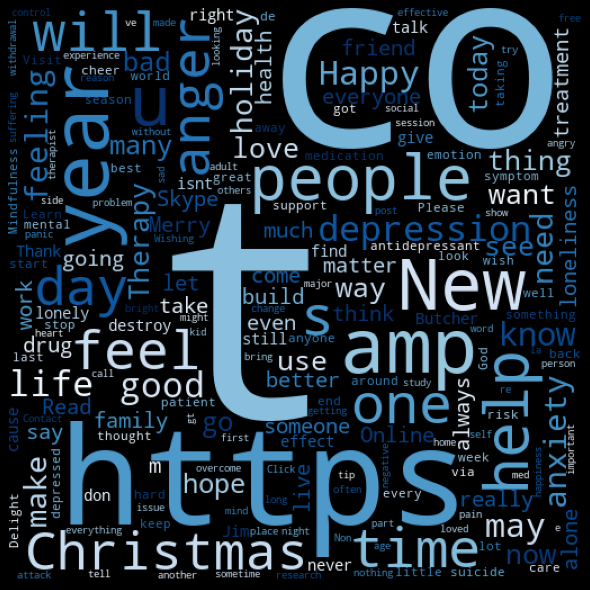

In [21]:
depressive_words = ' '.join(list(tweets[tweets["target"] == 1]["tweet"]))
depressive_wc = WordCloud(width = 512, height =  512, collocations=False, colormap="Blues").generate(depressive_words)

plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

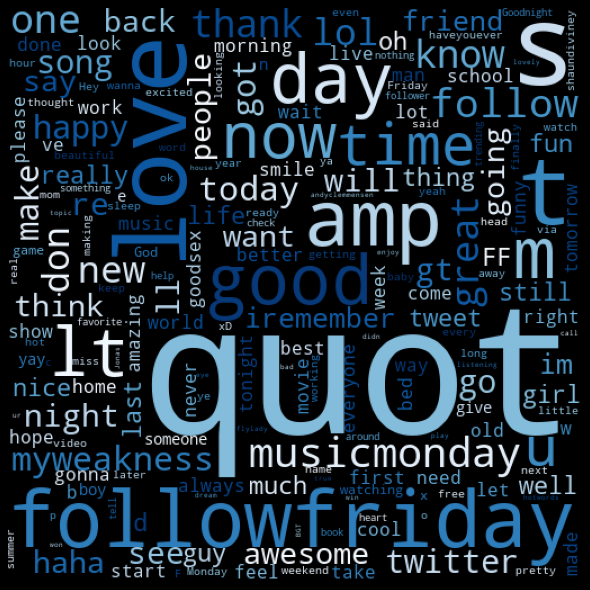

In [22]:
non_depressive_words = ' '.join(list(tweets[tweets["target"] == 0]["tweet"]))
non_depressive_wc = WordCloud(width = 512, height =  512, collocations=False, colormap="Blues").generate(non_depressive_words)

plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(non_depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [23]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [27]:

class TweetClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.tweets, self.labels = train['tweet'], train['target']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 


    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels.iloc[i]:
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    self.depressive_words += 1
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
            
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive.get(word, 0) + self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
    
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 
                    
    def classify(self, processed_message):
        pDepressive, pPositive = 0, 0
        for word in processed_message:                
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys()))) 
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
        return pDepressive >= pPositive
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [25]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [29]:
sc_tf_idf = TweetClassifier(train, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(test['tweet'])
metrics(test['target'], preds_tf_idf)

Precision:  0.859375
Recall:  0.7236842105263158
F-score:  0.7857142857142857
Accuracy:  0.7761194029850746


In [30]:
sc_bow = TweetClassifier(train, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(test['tweet'])
metrics(test['target'], preds_bow)

Precision:  0.9404761904761905
Recall:  0.5197368421052632
F-score:  0.6694915254237289
Accuracy:  0.7089552238805971


In [31]:
pm = process_message('Lately I have been feeling unsure of myself as a person & an artist')
sc_tf_idf.classify(pm)

True

In [32]:
pm = process_message('Loving how me and my lovely partner is talking about what we want.')
sc_tf_idf.classify(pm)

False

In [33]:
pm = process_message('Hi hello depression and anxiety are the worst')
sc_bow.classify(pm)

True

In [34]:
pm = process_message('Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits')
sc_bow.classify(pm)

True

In [35]:
pm = process_message("I hate myself. But I love myself")
sc_bow.classify(pm)

False